# QC: Synthetic Data Generator Validation

This notebook validates the synthetic data generator (`starfinder.testdata`) by checking:
1. Dataset structure and file existence
2. Two-base encoding correctness
3. Spot positions and visualization
4. Channel assignments
5. 3D visualization with matplotlib

In [2]:
# Setup - imports
import sys
sys.path.insert(0, "../src/python")

import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from starfinder.testdata import get_preset_config
from starfinder.testdata.synthetic import (
    encode_barcode_to_colors,
    TEST_CODEBOOK,
    COLOR_TO_CHANNEL,
)
from starfinder.io import load_multipage_tiff, load_image_stacks

# Path to mini dataset
MINI_DATASET_PATH = Path("tests/fixtures/synthetic/mini")
print(f"Dataset path: {MINI_DATASET_PATH.absolute()}")
print(f"Dataset exists: {MINI_DATASET_PATH.exists()}")

Dataset path: /home/unix/jiahao/Github/starfinder/tests/fixtures/synthetic/mini
Dataset exists: True


## 1. Verify Dataset Structure

Check that all expected files and directories exist in the mini dataset.

In [3]:
# Check all files/dirs exist
def check_dataset_structure(dataset_path: Path):
    """Verify all expected files and directories exist."""
    checks = []
    
    # Top-level files
    checks.append(("codebook.csv", (dataset_path / "codebook.csv").exists()))
    checks.append(("ground_truth.json", (dataset_path / "ground_truth.json").exists()))
    
    # Load config to get expected structure
    config = get_preset_config("mini")
    
    # Check FOV directories
    for fov_idx in range(config.n_fovs):
        fov_id = f"FOV_{fov_idx + 1:03d}"
        fov_dir = dataset_path / fov_id
        checks.append((f"{fov_id}/", fov_dir.exists()))
        
        # Check round directories
        for round_idx in range(1, config.n_rounds + 1):
            round_dir = fov_dir / f"round{round_idx}"
            checks.append((f"{fov_id}/round{round_idx}/", round_dir.exists()))
            
            # Check channel files
            for ch in range(config.n_channels):
                tiff_path = round_dir / f"ch{ch:02d}.tif"
                checks.append((f"{fov_id}/round{round_idx}/ch{ch:02d}.tif", tiff_path.exists()))
    
    # Print results
    print("Dataset Structure Check:")
    print("=" * 50)
    all_passed = True
    for name, exists in checks:
        status = "PASS" if exists else "FAIL"
        if not exists:
            all_passed = False
        print(f"  [{status}] {name}")
    
    print("=" * 50)
    print(f"Overall: {'ALL CHECKS PASSED' if all_passed else 'SOME CHECKS FAILED'}")
    return all_passed

check_dataset_structure(MINI_DATASET_PATH)

Dataset Structure Check:
  [PASS] codebook.csv
  [PASS] ground_truth.json
  [PASS] FOV_001/
  [PASS] FOV_001/round1/
  [PASS] FOV_001/round1/ch00.tif
  [PASS] FOV_001/round1/ch01.tif
  [PASS] FOV_001/round1/ch02.tif
  [PASS] FOV_001/round1/ch03.tif
  [PASS] FOV_001/round2/
  [PASS] FOV_001/round2/ch00.tif
  [PASS] FOV_001/round2/ch01.tif
  [PASS] FOV_001/round2/ch02.tif
  [PASS] FOV_001/round2/ch03.tif
  [PASS] FOV_001/round3/
  [PASS] FOV_001/round3/ch00.tif
  [PASS] FOV_001/round3/ch01.tif
  [PASS] FOV_001/round3/ch02.tif
  [PASS] FOV_001/round3/ch03.tif
  [PASS] FOV_001/round4/
  [PASS] FOV_001/round4/ch00.tif
  [PASS] FOV_001/round4/ch01.tif
  [PASS] FOV_001/round4/ch02.tif
  [PASS] FOV_001/round4/ch03.tif
Overall: ALL CHECKS PASSED


True

## 2. Validate Two-Base Encoding

Verify that the two-base encoding works correctly for all genes in TEST_CODEBOOK.

In [4]:
# Print encoding for all genes in TEST_CODEBOOK, verify CACGC -> 4422
print("Two-Base Encoding Validation:")
print("=" * 60)
print(f"{'Gene':<10} {'Barcode':<10} {'Reversed':<10} {'Color Seq':<12} {'Expected'}")
print("-" * 60)

# Known expected encoding for CACGC
# CACGC reversed = CGCAC
# CG -> 4, GC -> 4, CA -> 2, AC -> 2 => "4422"
expected_encodings = {
    "CACGC": "4422",  # Explicitly stated in task
}

all_valid = True
for gene, barcode in TEST_CODEBOOK:
    color_seq = encode_barcode_to_colors(barcode)
    reversed_barcode = barcode[::-1]
    
    # Check if we have an expected value
    expected = expected_encodings.get(barcode, "--")
    if expected != "--":
        match = "MATCH" if color_seq == expected else "MISMATCH"
        if color_seq != expected:
            all_valid = False
    else:
        match = ""
    
    print(f"{gene:<10} {barcode:<10} {reversed_barcode:<10} {color_seq:<12} {expected:<8} {match}")

print("=" * 60)
print(f"\nVerification: CACGC -> {encode_barcode_to_colors('CACGC')} (expected: 4422)")
print(f"Result: {'PASS' if encode_barcode_to_colors('CACGC') == '4422' else 'FAIL'}")

Two-Base Encoding Validation:
Gene       Barcode    Reversed   Color Seq    Expected
------------------------------------------------------------
GeneA      CACGC      CGCAC      4422         4422     MATCH
GeneB      CATGC      CGTAC      4242         --       
GeneC      CGAAC      CAAGC      2134         --       
GeneD      CGTAC      CATGC      2424         --       
GeneE      CTGAC      CAGTC      2323         --       
GeneF      CTAGC      CGATC      4343         --       
GeneG      CCATC      CTACC      3421         --       
GeneH      CGCTC      CTCGC      3344         --       

Verification: CACGC -> 4422 (expected: 4422)
Result: PASS


## 3. Verify Spot Positions

Load ground_truth.json and overlay spots on max projection.

Ground truth version: 1.0
Image shape (Z, Y, X): [5, 256, 256]
Number of rounds: 4
Number of channels: 4
Number of FOVs: 1

Number of spots in FOV_001: 20


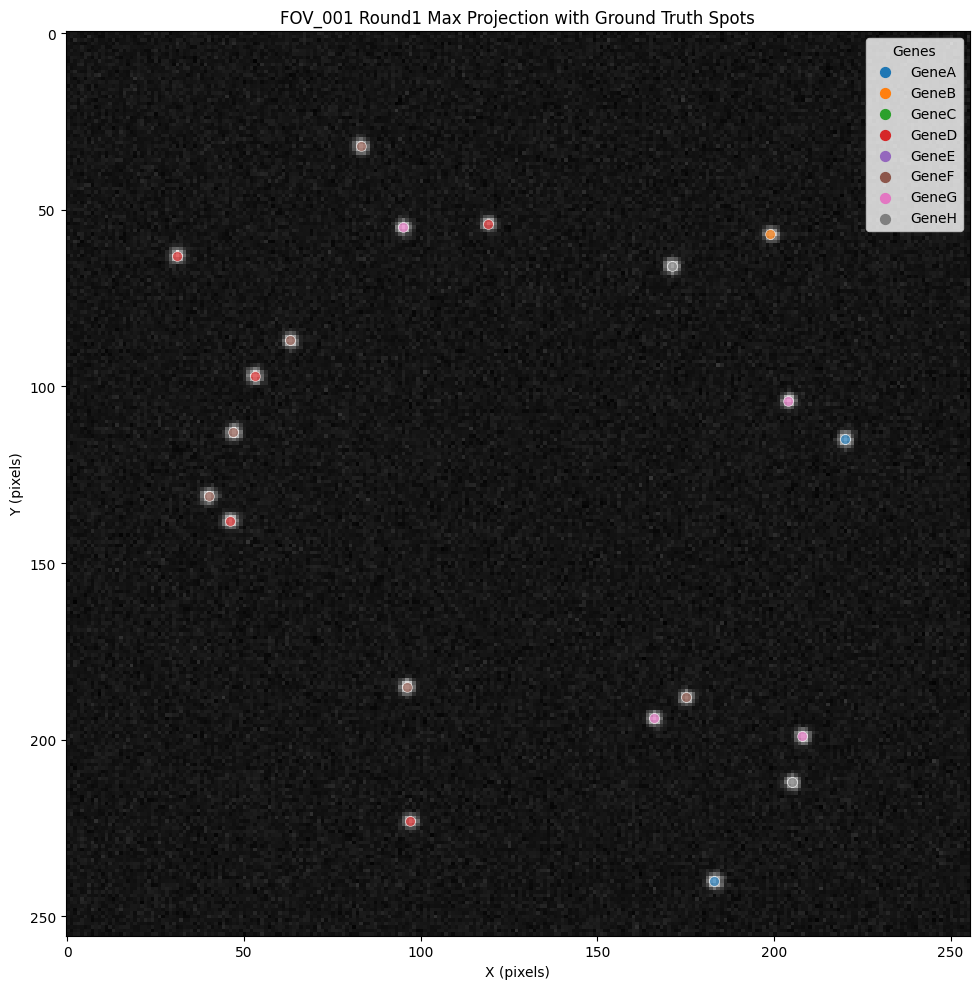


First 5 spots:
  GeneA: pos=[2, 240, 183], barcode=CACGC, color_seq=4422
  GeneF: pos=[3, 131, 40], barcode=CTAGC, color_seq=4343
  GeneD: pos=[2, 97, 53], barcode=CGTAC, color_seq=2424
  GeneG: pos=[2, 104, 204], barcode=CCATC, color_seq=3421
  GeneD: pos=[2, 63, 31], barcode=CGTAC, color_seq=2424


In [5]:
# Load ground_truth.json, overlay spots on max projection using matplotlib

# Load ground truth
with open(MINI_DATASET_PATH / "ground_truth.json") as f:
    ground_truth = json.load(f)

print(f"Ground truth version: {ground_truth['version']}")
print(f"Image shape (Z, Y, X): {ground_truth['image_shape']}")
print(f"Number of rounds: {ground_truth['n_rounds']}")
print(f"Number of channels: {ground_truth['n_channels']}")
print(f"Number of FOVs: {len(ground_truth['fovs'])}")

# Get FOV_001 data
fov_data = ground_truth["fovs"]["FOV_001"]
spots = fov_data["spots"]
print(f"\nNumber of spots in FOV_001: {len(spots)}")

# Load round1 images and create max projection
round1_dir = MINI_DATASET_PATH / "FOV_001" / "round1"
max_proj = None
for ch in range(4):
    img = load_multipage_tiff(round1_dir / f"ch{ch:02d}.tif", convert_uint8=False)
    ch_max = img.max(axis=0)
    if max_proj is None:
        max_proj = ch_max.astype(np.float32)
    else:
        max_proj = np.maximum(max_proj, ch_max)

# Plot with spot overlays
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(max_proj, cmap="gray")
ax.set_title("FOV_001 Round1 Max Projection with Ground Truth Spots")

# Overlay spots
colors = plt.cm.tab10.colors
gene_to_color = {gene: colors[i % len(colors)] for i, (gene, _) in enumerate(TEST_CODEBOOK)}

for spot in spots:
    z, y, x = spot["position"]
    gene = spot["gene"]
    ax.scatter(x, y, c=[gene_to_color[gene]], s=50, marker="o", alpha=0.7, edgecolors="white", linewidths=0.5)

# Add legend
for gene, color in gene_to_color.items():
    ax.scatter([], [], c=[color], label=gene, s=50)
ax.legend(loc="upper right", title="Genes")

ax.set_xlabel("X (pixels)")
ax.set_ylabel("Y (pixels)")
plt.tight_layout()
plt.show()

# Print first few spots
print("\nFirst 5 spots:")
for spot in spots[:5]:
    print(f"  {spot['gene']}: pos={spot['position']}, barcode={spot['barcode']}, color_seq={spot['color_seq']}")

## 4. Verify Spots Appear in Correct Channels

Check that each spot appears in the expected channel based on its color_seq.

In [6]:
# Check that spots appear in expected channels based on color_seq

def verify_spot_in_channel(img_stack, z, y, x, expected_intensity_above_bg=50):
    """Check if a spot exists at the given location.
    
    Returns the intensity at the spot location and whether it's above background.
    """
    # Get local region around spot
    z_min, z_max = max(0, z-1), min(img_stack.shape[0], z+2)
    y_min, y_max = max(0, y-2), min(img_stack.shape[1], y+3)
    x_min, x_max = max(0, x-2), min(img_stack.shape[2], x+3)
    
    local_region = img_stack[z_min:z_max, y_min:y_max, x_min:x_max]
    max_intensity = local_region.max()
    
    # Estimate background from image corners
    bg_estimate = np.mean([
        img_stack[:, :10, :10].mean(),
        img_stack[:, :10, -10:].mean(),
        img_stack[:, -10:, :10].mean(),
        img_stack[:, -10:, -10:].mean(),
    ])
    
    is_above_bg = max_intensity > (bg_estimate + expected_intensity_above_bg)
    return max_intensity, is_above_bg, bg_estimate

# Load all round1 channels
round1_dir = MINI_DATASET_PATH / "FOV_001" / "round1"
channel_stacks = []
for ch in range(4):
    img = load_multipage_tiff(round1_dir / f"ch{ch:02d}.tif", convert_uint8=False)
    channel_stacks.append(img)

print("Spot Channel Verification (Round 1):")
print("=" * 80)
print(f"{'Spot':<6} {'Gene':<8} {'Position':<15} {'Expected Ch':<12} {'Intensities (ch0-3)':<30} {'Pass'}")
print("-" * 80)

n_passed = 0
n_total = len(spots)

for i, spot in enumerate(spots):
    z, y, x = spot["position"]
    gene = spot["gene"]
    color_seq = spot["color_seq"]
    
    # Round 1 corresponds to first color in sequence (index 0)
    expected_color = color_seq[0]
    expected_channel = COLOR_TO_CHANNEL[expected_color]
    
    # Get intensities at spot location for all channels
    intensities = []
    for ch in range(4):
        max_int, is_above, bg = verify_spot_in_channel(channel_stacks[ch], z, y, x)
        intensities.append(max_int)
    
    # Check if expected channel has highest intensity
    max_ch = np.argmax(intensities)
    passed = max_ch == expected_channel
    if passed:
        n_passed += 1
    
    pos_str = f"({z},{y},{x})"
    int_str = ", ".join([f"{int(v):3d}" for v in intensities])
    status = "PASS" if passed else f"FAIL (got ch{max_ch})"
    
    print(f"{i:<6} {gene:<8} {pos_str:<15} ch{expected_channel:<11} [{int_str}]  {status}")

print("=" * 80)
print(f"Summary: {n_passed}/{n_total} spots appear in correct channel ({100*n_passed/n_total:.1f}%)")

Spot Channel Verification (Round 1):
Spot   Gene     Position        Expected Ch  Intensities (ch0-3)            Pass
--------------------------------------------------------------------------------
0      GeneA    (2,240,183)     ch3           [ 43,  54,  40, 255]  PASS
1      GeneF    (3,131,40)      ch3           [ 39,  54,  46, 255]  PASS
2      GeneD    (2,97,53)       ch1           [ 46, 255,  47,  41]  PASS
3      GeneG    (2,104,204)     ch2           [ 46,  49, 254,  50]  PASS
4      GeneD    (2,63,31)       ch1           [ 38, 255,  45,  48]  PASS
5      GeneH    (1,212,205)     ch2           [ 52,  44, 230,  48]  PASS
6      GeneF    (1,188,175)     ch3           [ 43,  43,  43, 227]  PASS
7      GeneA    (3,115,220)     ch3           [ 44,  47,  45, 255]  PASS
8      GeneG    (3,55,95)       ch2           [ 40,  44, 255,  44]  PASS
9      GeneD    (1,138,46)      ch1           [ 53, 239,  43,  47]  PASS
10     GeneF    (3,185,96)      ch3           [ 53,  49,  43, 255]  PAS

## 5. 3D Visualization with Matplotlib

Visualize spot positions across Z-slices and in 3D space.

In [ ]:
# Matplotlib 3D visualization (works without OpenGL)
from mpl_toolkits.mplot3d import Axes3D

# Load round1 as 4-channel stack
round1_dir = MINI_DATASET_PATH / "FOV_001" / "round1"
channel_order = [f"ch{i:02d}" for i in range(4)]
volume, metadata = load_image_stacks(round1_dir, channel_order=channel_order)
print(f"Volume shape (Z, Y, X, C): {volume.shape}")

# Extract spot positions
spot_positions = np.array([spot["position"] for spot in spots])  # (N, 3) as [z, y, x]
spot_genes = [spot["gene"] for spot in spots]

# Gene colors
gene_colors = {
    "GeneA": "red", "GeneB": "green", "GeneC": "blue", "GeneD": "gold",
    "GeneE": "magenta", "GeneF": "cyan", "GeneG": "orange", "GeneH": "pink",
}
spot_colors = [gene_colors.get(g, "gray") for g in spot_genes]

fig = plt.figure(figsize=(14, 5))

# Panel 1: Z-slice montage with spots
ax1 = fig.add_subplot(1, 2, 1)
n_z = volume.shape[0]
montage_cols = n_z
montage = np.hstack([volume[z].max(axis=-1) for z in range(n_z)])  # max across channels
ax1.imshow(montage, cmap="gray")
ax1.set_title(f"Z-slices (0-{n_z-1}) with spot positions")

# Overlay spots on correct Z-slice position in montage
for i, (z, y, x) in enumerate(spot_positions):
    x_montage = x + z * volume.shape[2]  # offset by slice
    ax1.scatter(x_montage, y, c=spot_colors[i], s=30, edgecolors="white", linewidths=0.5)

ax1.set_xlabel("X (tiled by Z)")
ax1.set_ylabel("Y")

# Panel 2: 3D scatter of spot positions
ax2 = fig.add_subplot(1, 2, 2, projection="3d")
for gene in gene_colors:
    mask = [g == gene for g in spot_genes]
    if any(mask):
        pts = spot_positions[mask]
        ax2.scatter(pts[:, 2], pts[:, 1], pts[:, 0], c=gene_colors[gene], label=gene, s=50)

ax2.set_xlabel("X")
ax2.set_ylabel("Y")
ax2.set_zlabel("Z")
ax2.set_title("3D Spot Positions")
ax2.legend(loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

print(f"\nVisualized {len(spots)} spots across {n_z} Z-slices.")

## Summary Checklist

| Check | Description | Status |
|-------|-------------|--------|
| 1 | Dataset structure (all files/dirs exist) | Run cell 2 |
| 2 | Two-base encoding (CACGC -> 4422) | Run cell 3 |
| 3 | Spot positions overlay on max projection | Run cell 4 |
| 4 | Spots appear in correct channels | Run cell 5 |
| 5 | 3D visualization (matplotlib) | Run cell 6 |

### Expected Results

- **Structure**: All 16 TIFF files (4 rounds x 4 channels) should exist for FOV_001
- **Encoding**: `CACGC` should encode to `4422` using the two-base color-space encoding
- **Spots**: 20 spots should be visible in the max projection, colored by gene
- **Channels**: Each spot should have highest intensity in the channel corresponding to its color_seq
- **3D View**: Z-slice montage and 3D scatter plot showing spot distribution